# LR = 5e-4

Epoch 1: Loss = 70.3833, Train Acc = 0.5808, Dev Acc = 0.6618
Epoch 2: Loss = 61.2744, Train Acc = 0.7209, Dev Acc = 0.7230
Epoch 3: Loss = 48.9641, Train Acc = 0.7907, Dev Acc = 0.7304
Epoch 4: Loss = 37.3858, Train Acc = 0.8592, Dev Acc = 0.7672
Epoch 5: Loss = 29.5866, Train Acc = 0.8953, Dev Acc = 0.7696
Epoch 6: Loss = 21.9207, Train Acc = 0.9284, Dev Acc = 0.7426
Epoch 7: Loss = 13.8890, Train Acc = 0.9621, Dev Acc = 0.7157
Epoch 8: Loss = 8.7300, Train Acc = 0.9780, Dev Acc = 0.7181
Epoch 9: Loss = 5.6346, Train Acc = 0.9890, Dev Acc = 0.7279
Epoch 10: Loss = 3.4616, Train Acc = 0.9927, Dev Acc = 0.7623


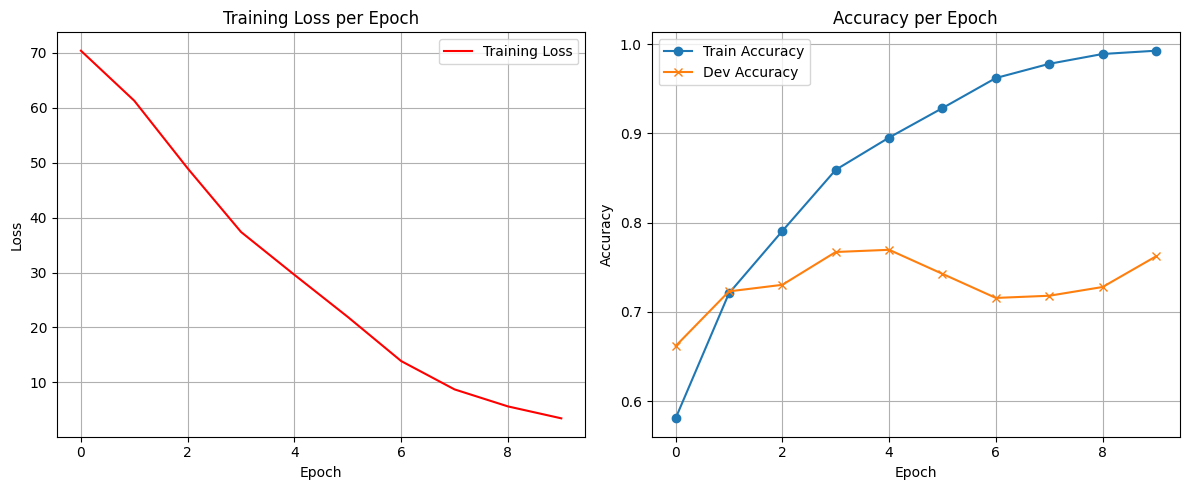


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8408    0.6471    0.7313       204
           1     0.7131    0.8775    0.7868       204

    accuracy                         0.7623       408
   macro avg     0.7770    0.7623    0.7591       408
weighted avg     0.7770    0.7623    0.7591       408

Confusion Matrix:
 [[132  72]
 [ 25 179]]


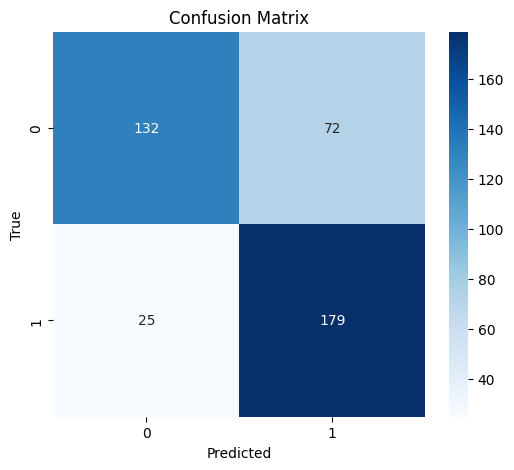


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8152    0.6598    0.7293       341
           1     0.7143    0.8504    0.7764       341

    accuracy                         0.7551       682
   macro avg     0.7648    0.7551    0.7529       682
weighted avg     0.7648    0.7551    0.7529       682

Confusion Matrix:
 [[225 116]
 [ 51 290]]


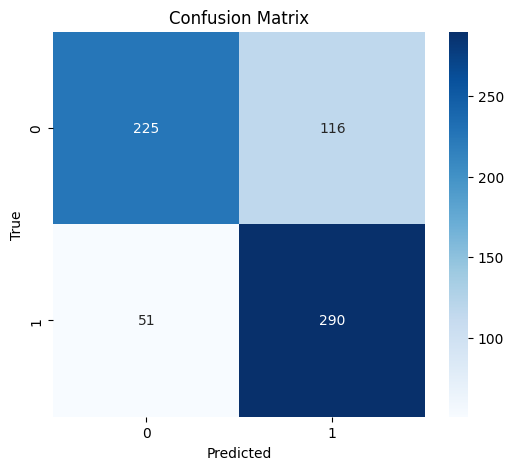

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 16
    lr = 5e-4
    epochs = 10
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# LR = 1e-2

Epoch 1: Loss = 60.1600, Train Acc = 0.6940, Dev Acc = 0.7868
Epoch 2: Loss = 13.0986, Train Acc = 0.9590, Dev Acc = 0.8039
Epoch 3: Loss = 1.9922, Train Acc = 0.9951, Dev Acc = 0.7721
Epoch 4: Loss = 0.2183, Train Acc = 1.0000, Dev Acc = 0.7794
Epoch 5: Loss = 0.0529, Train Acc = 1.0000, Dev Acc = 0.7819
Epoch 6: Loss = 0.0190, Train Acc = 1.0000, Dev Acc = 0.7770
Epoch 7: Loss = 0.0097, Train Acc = 1.0000, Dev Acc = 0.7794
Epoch 8: Loss = 0.0082, Train Acc = 1.0000, Dev Acc = 0.7843
Epoch 9: Loss = 0.0068, Train Acc = 1.0000, Dev Acc = 0.7843
Epoch 10: Loss = 0.0070, Train Acc = 1.0000, Dev Acc = 0.7843


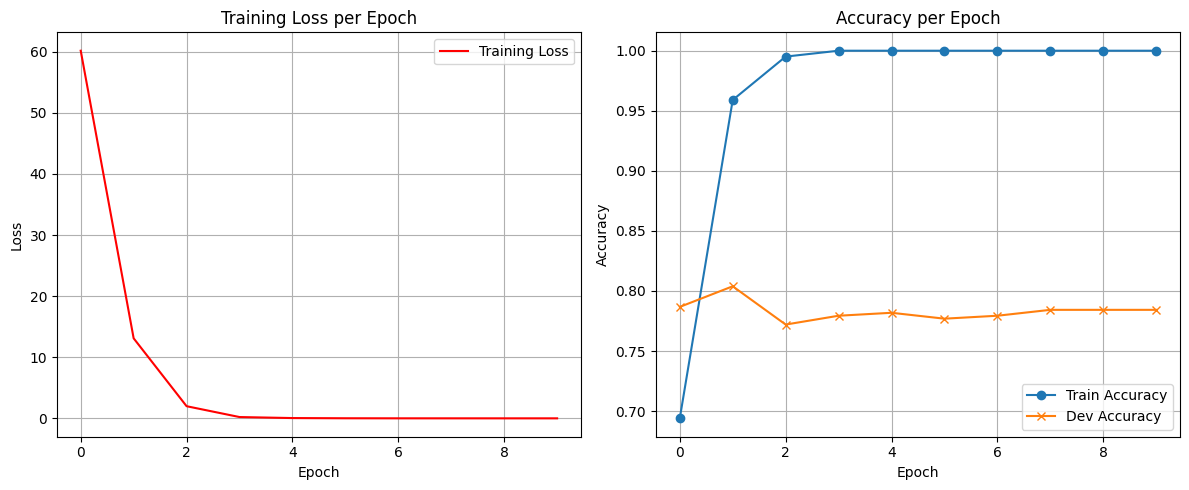


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8412    0.7010    0.7647       204
           1     0.7437    0.8676    0.8009       204

    accuracy                         0.7843       408
   macro avg     0.7924    0.7843    0.7828       408
weighted avg     0.7924    0.7843    0.7828       408

Confusion Matrix:
 [[143  61]
 [ 27 177]]


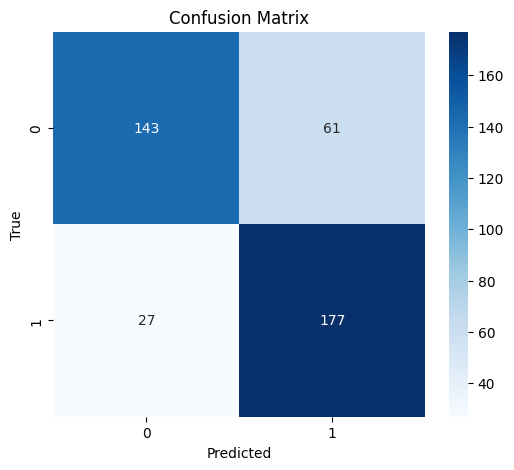


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8082    0.7537    0.7800       341
           1     0.7692    0.8211    0.7943       341

    accuracy                         0.7874       682
   macro avg     0.7887    0.7874    0.7871       682
weighted avg     0.7887    0.7874    0.7871       682

Confusion Matrix:
 [[257  84]
 [ 61 280]]


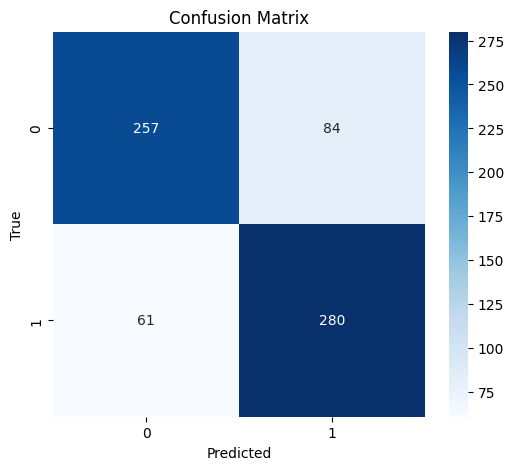

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 16
    lr = 1e-2
    epochs = 10
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# LR = 1e-1

Epoch 1: Loss = 83.9003, Train Acc = 0.5245, Dev Acc = 0.5637
Epoch 2: Loss = 77.5416, Train Acc = 0.6616, Dev Acc = 0.5858
Epoch 3: Loss = 73.4295, Train Acc = 0.7026, Dev Acc = 0.5245
Epoch 4: Loss = 77.0151, Train Acc = 0.7020, Dev Acc = 0.5123
Epoch 5: Loss = 71.3305, Train Acc = 0.7283, Dev Acc = 0.5784
Epoch 6: Loss = 71.7036, Train Acc = 0.7185, Dev Acc = 0.5392
Epoch 7: Loss = 71.3212, Train Acc = 0.7289, Dev Acc = 0.5368
Epoch 8: Loss = 73.9070, Train Acc = 0.7142, Dev Acc = 0.5466
Epoch 9: Loss = 64.3284, Train Acc = 0.7509, Dev Acc = 0.5613
Epoch 10: Loss = 73.7112, Train Acc = 0.7173, Dev Acc = 0.5858


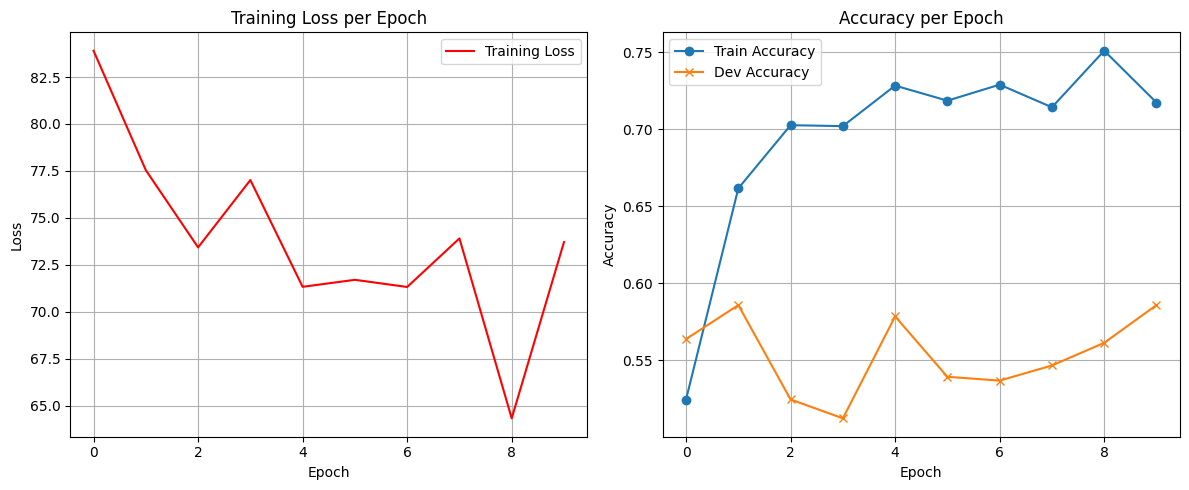


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.6012    0.5098    0.5517       204
           1     0.5745    0.6618    0.6150       204

    accuracy                         0.5858       408
   macro avg     0.5878    0.5858    0.5834       408
weighted avg     0.5878    0.5858    0.5834       408

Confusion Matrix:
 [[104 100]
 [ 69 135]]


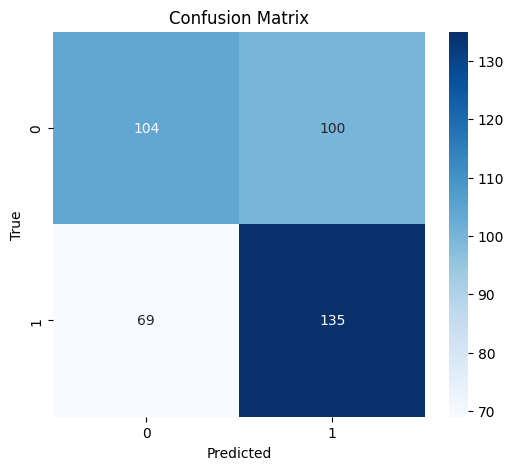


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.5615    0.5220    0.5410       341
           1     0.5534    0.5924    0.5722       341

    accuracy                         0.5572       682
   macro avg     0.5575    0.5572    0.5566       682
weighted avg     0.5575    0.5572    0.5566       682

Confusion Matrix:
 [[178 163]
 [139 202]]


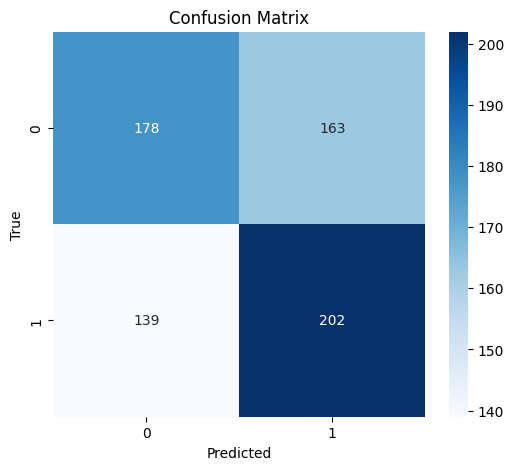

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 16
    lr = 1e-1
    epochs = 10
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# BS = 16

Epoch 1: Loss = 57.8292, Train Acc = 0.6983, Dev Acc = 0.7819
Epoch 2: Loss = 14.9081, Train Acc = 0.9431, Dev Acc = 0.7917
Epoch 3: Loss = 2.7267, Train Acc = 0.9908, Dev Acc = 0.7966
Epoch 4: Loss = 0.4473, Train Acc = 0.9988, Dev Acc = 0.7819
Epoch 5: Loss = 0.1413, Train Acc = 1.0000, Dev Acc = 0.7941
Epoch 6: Loss = 0.1023, Train Acc = 0.9994, Dev Acc = 0.7966
Epoch 7: Loss = 0.0346, Train Acc = 1.0000, Dev Acc = 0.8064
Epoch 8: Loss = 0.0129, Train Acc = 1.0000, Dev Acc = 0.8088
Epoch 9: Loss = 0.0104, Train Acc = 1.0000, Dev Acc = 0.8088
Epoch 10: Loss = 0.0071, Train Acc = 1.0000, Dev Acc = 0.8088


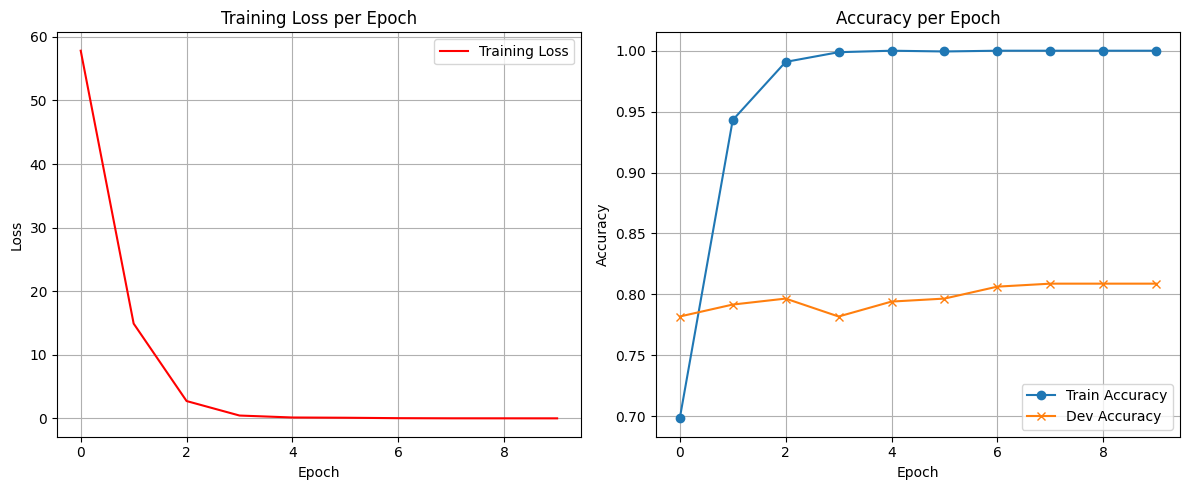


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7864    0.8480    0.8160       204
           1     0.8351    0.7696    0.8010       204

    accuracy                         0.8088       408
   macro avg     0.8107    0.8088    0.8085       408
weighted avg     0.8107    0.8088    0.8085       408

Confusion Matrix:
 [[173  31]
 [ 47 157]]


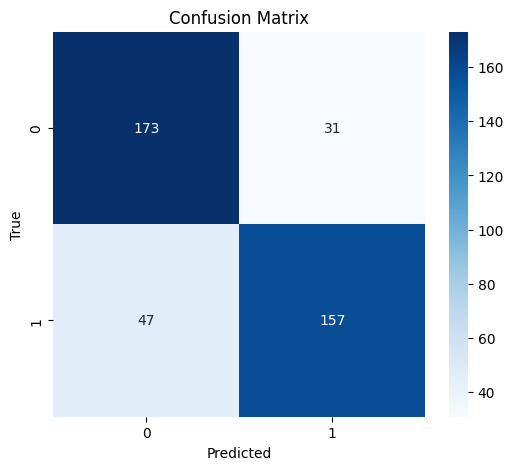


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7602    0.8739    0.8131       341
           1     0.8517    0.7243    0.7829       341

    accuracy                         0.7991       682
   macro avg     0.8060    0.7991    0.7980       682
weighted avg     0.8060    0.7991    0.7980       682

Confusion Matrix:
 [[298  43]
 [ 94 247]]


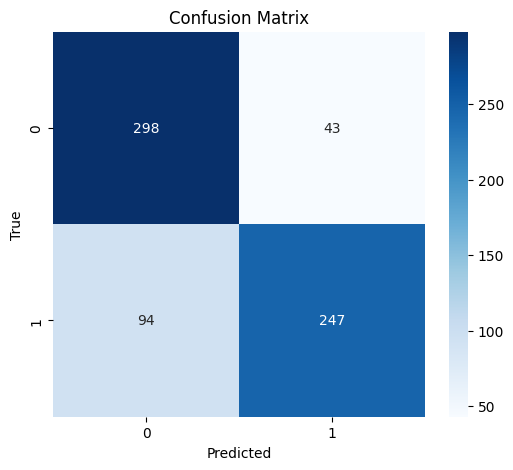

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 16
    lr = 1e-2
    epochs = 10
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# BS = 32

Epoch 1: Loss = 30.6784, Train Acc = 0.6842, Dev Acc = 0.7451
Epoch 2: Loss = 7.8256, Train Acc = 0.9510, Dev Acc = 0.7868
Epoch 3: Loss = 1.4989, Train Acc = 0.9890, Dev Acc = 0.7941
Epoch 4: Loss = 0.7249, Train Acc = 0.9988, Dev Acc = 0.7917
Epoch 5: Loss = 0.0643, Train Acc = 1.0000, Dev Acc = 0.7941
Epoch 6: Loss = 0.0206, Train Acc = 1.0000, Dev Acc = 0.7990
Epoch 7: Loss = 0.0162, Train Acc = 1.0000, Dev Acc = 0.7843
Epoch 8: Loss = 0.0119, Train Acc = 1.0000, Dev Acc = 0.7843
Epoch 9: Loss = 0.0064, Train Acc = 1.0000, Dev Acc = 0.7843
Epoch 10: Loss = 0.0060, Train Acc = 1.0000, Dev Acc = 0.7843


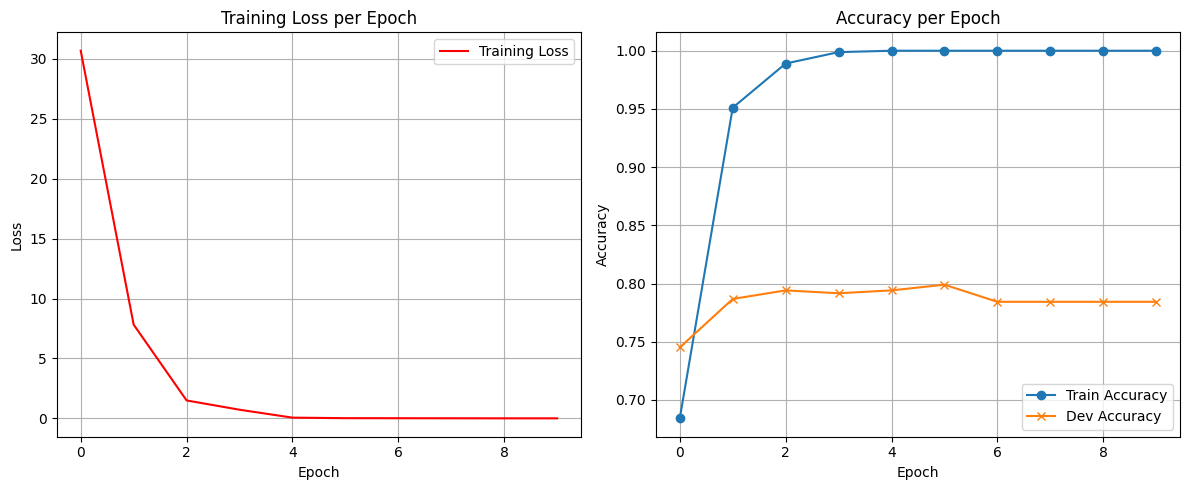


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7736    0.8039    0.7885       204
           1     0.7959    0.7647    0.7800       204

    accuracy                         0.7843       408
   macro avg     0.7848    0.7843    0.7842       408
weighted avg     0.7848    0.7843    0.7842       408

Confusion Matrix:
 [[164  40]
 [ 48 156]]


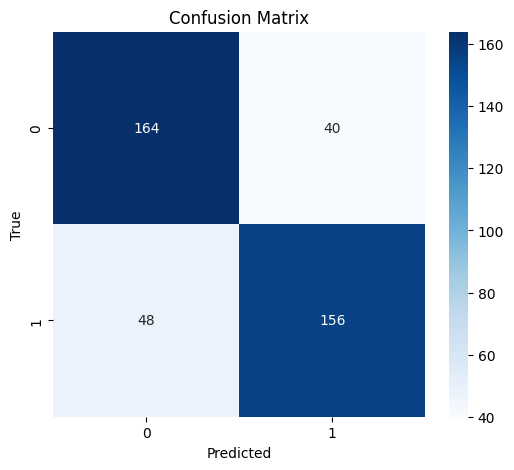


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7500    0.8446    0.7945       341
           1     0.8221    0.7185    0.7668       341

    accuracy                         0.7815       682
   macro avg     0.7861    0.7815    0.7807       682
weighted avg     0.7861    0.7815    0.7807       682

Confusion Matrix:
 [[288  53]
 [ 96 245]]


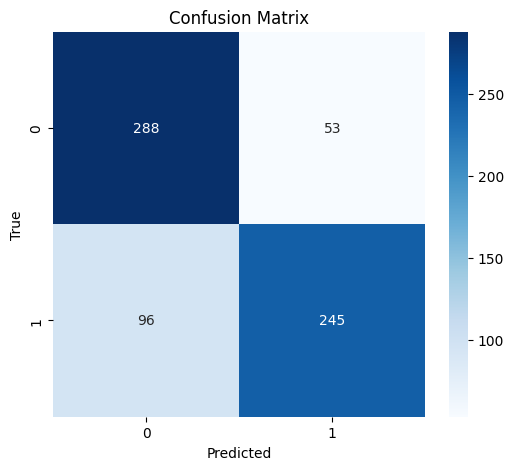

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-2
    epochs = 10
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# BS = 64

Epoch 1: Loss = 17.5787, Train Acc = 0.6304, Dev Acc = 0.6446
Epoch 2: Loss = 8.8285, Train Acc = 0.8960, Dev Acc = 0.7451
Epoch 3: Loss = 1.3794, Train Acc = 0.9786, Dev Acc = 0.7892
Epoch 4: Loss = 0.3124, Train Acc = 0.9976, Dev Acc = 0.7525
Epoch 5: Loss = 0.0904, Train Acc = 0.9994, Dev Acc = 0.7966
Epoch 6: Loss = 0.0658, Train Acc = 0.9994, Dev Acc = 0.7843
Epoch 7: Loss = 0.0350, Train Acc = 0.9994, Dev Acc = 0.7868
Epoch 8: Loss = 0.0447, Train Acc = 0.9994, Dev Acc = 0.7770
Epoch 9: Loss = 0.0089, Train Acc = 1.0000, Dev Acc = 0.7721
Epoch 10: Loss = 0.0068, Train Acc = 1.0000, Dev Acc = 0.7672


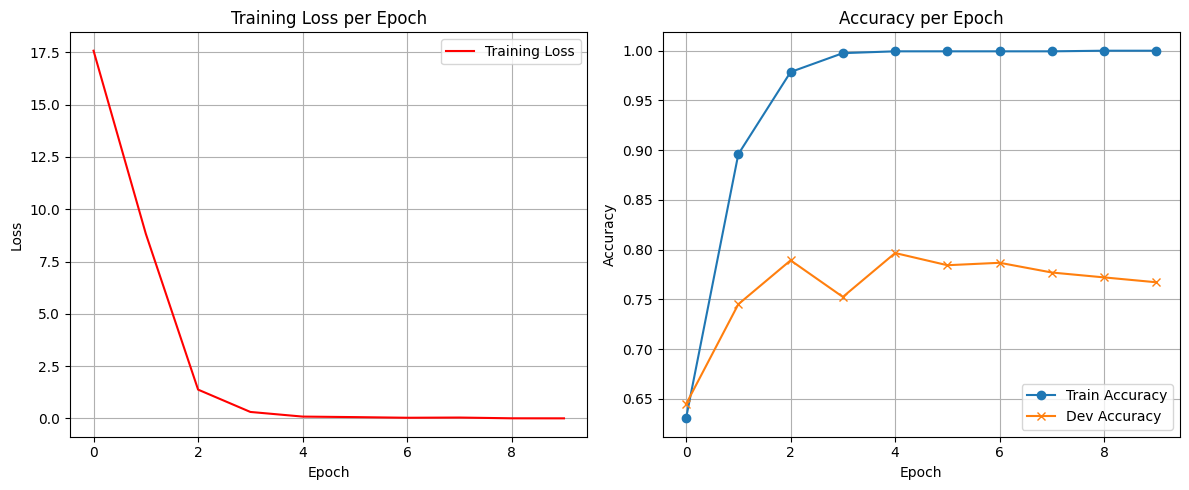


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7319    0.8431    0.7836       204
           1     0.8150    0.6912    0.7480       204

    accuracy                         0.7672       408
   macro avg     0.7735    0.7672    0.7658       408
weighted avg     0.7735    0.7672    0.7658       408

Confusion Matrix:
 [[172  32]
 [ 63 141]]


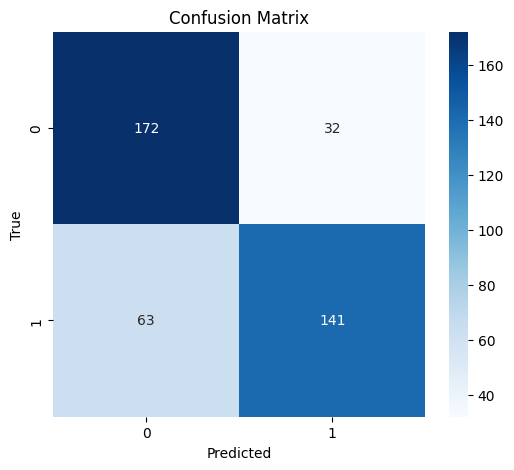


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7481    0.8886    0.8123       341
           1     0.8628    0.7009    0.7735       341

    accuracy                         0.7947       682
   macro avg     0.8055    0.7947    0.7929       682
weighted avg     0.8055    0.7947    0.7929       682

Confusion Matrix:
 [[303  38]
 [102 239]]


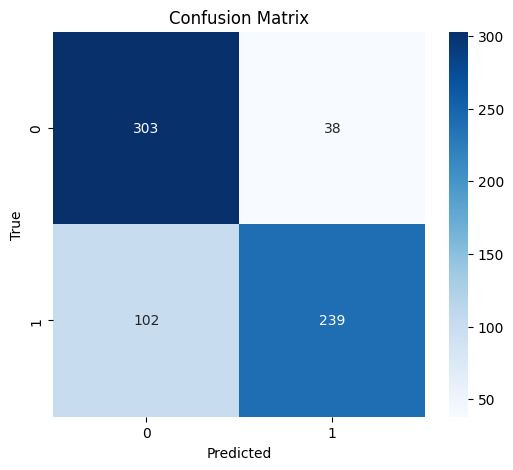

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 64
    lr = 1e-2
    epochs = 10
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


epoch = 10

Epoch 1: Loss = 58.0070, Train Acc = 0.7069, Dev Acc = 0.7990
Epoch 2: Loss = 12.6665, Train Acc = 0.9547, Dev Acc = 0.7892
Epoch 3: Loss = 2.1398, Train Acc = 0.9927, Dev Acc = 0.8088
Epoch 4: Loss = 1.2049, Train Acc = 0.9963, Dev Acc = 0.7990
Epoch 5: Loss = 0.3482, Train Acc = 0.9994, Dev Acc = 0.7941
Epoch 6: Loss = 0.0818, Train Acc = 1.0000, Dev Acc = 0.7868
Epoch 7: Loss = 0.0397, Train Acc = 1.0000, Dev Acc = 0.7917
Epoch 8: Loss = 0.0251, Train Acc = 1.0000, Dev Acc = 0.7868
Epoch 9: Loss = 0.0105, Train Acc = 1.0000, Dev Acc = 0.7917
Epoch 10: Loss = 0.0111, Train Acc = 1.0000, Dev Acc = 0.7941


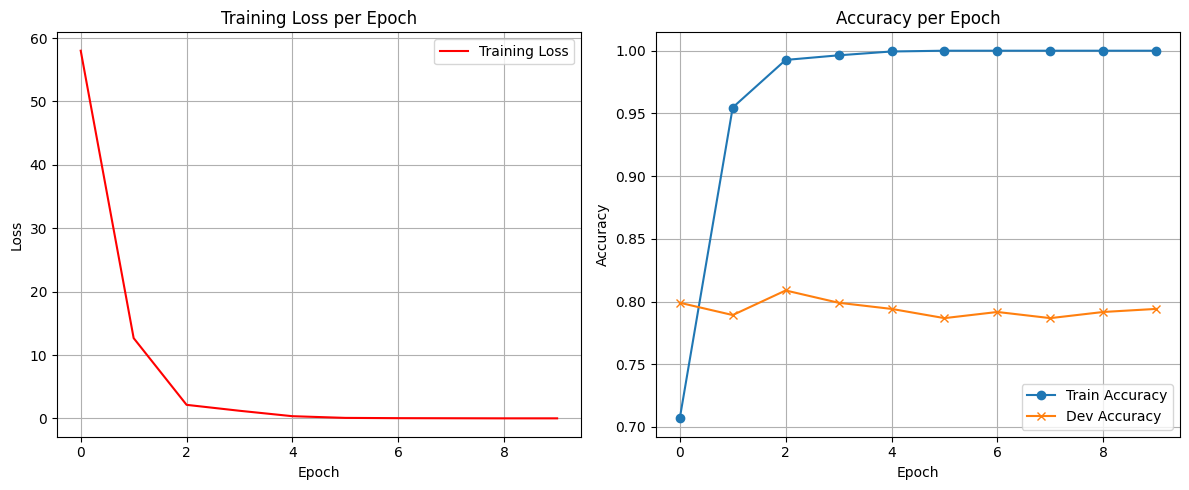


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7804    0.8186    0.7990       204
           1     0.8093    0.7696    0.7889       204

    accuracy                         0.7941       408
   macro avg     0.7948    0.7941    0.7940       408
weighted avg     0.7948    0.7941    0.7940       408

Confusion Matrix:
 [[167  37]
 [ 47 157]]


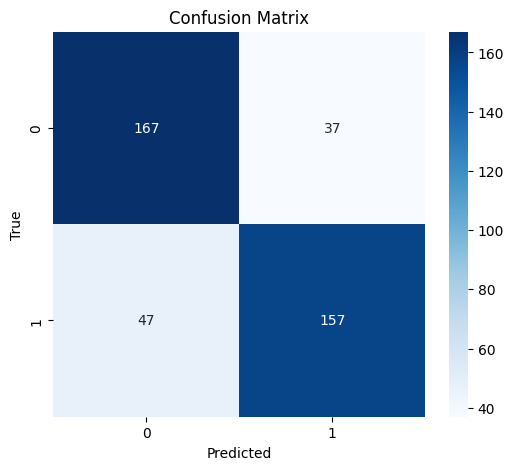


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7446    0.8035    0.7729       341
           1     0.7866    0.7243    0.7542       341

    accuracy                         0.7639       682
   macro avg     0.7656    0.7639    0.7636       682
weighted avg     0.7656    0.7639    0.7636       682

Confusion Matrix:
 [[274  67]
 [ 94 247]]


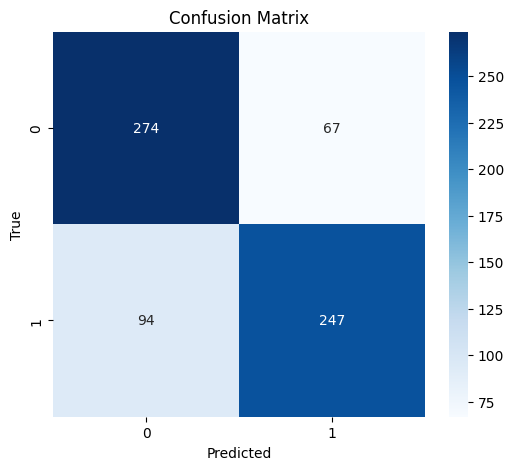

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 16
    lr = 1e-2
    epochs = 10
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# epoch = 15

Epoch 1: Loss = 62.5267, Train Acc = 0.6726, Dev Acc = 0.8064
Epoch 2: Loss = 14.0111, Train Acc = 0.9572, Dev Acc = 0.8137
Epoch 3: Loss = 2.9369, Train Acc = 0.9908, Dev Acc = 0.7819
Epoch 4: Loss = 1.1923, Train Acc = 0.9969, Dev Acc = 0.8064
Epoch 5: Loss = 0.2083, Train Acc = 0.9994, Dev Acc = 0.7990
Epoch 6: Loss = 0.0447, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 7: Loss = 0.0247, Train Acc = 1.0000, Dev Acc = 0.7990
Epoch 8: Loss = 0.0178, Train Acc = 1.0000, Dev Acc = 0.7990
Epoch 9: Loss = 0.0125, Train Acc = 1.0000, Dev Acc = 0.7990
Epoch 10: Loss = 0.0144, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 11: Loss = 0.0063, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 12: Loss = 0.0068, Train Acc = 1.0000, Dev Acc = 0.7917
Epoch 13: Loss = 0.0049, Train Acc = 1.0000, Dev Acc = 0.7941
Epoch 14: Loss = 0.0029, Train Acc = 1.0000, Dev Acc = 0.7917
Epoch 15: Loss = 0.0031, Train Acc = 1.0000, Dev Acc = 0.7966


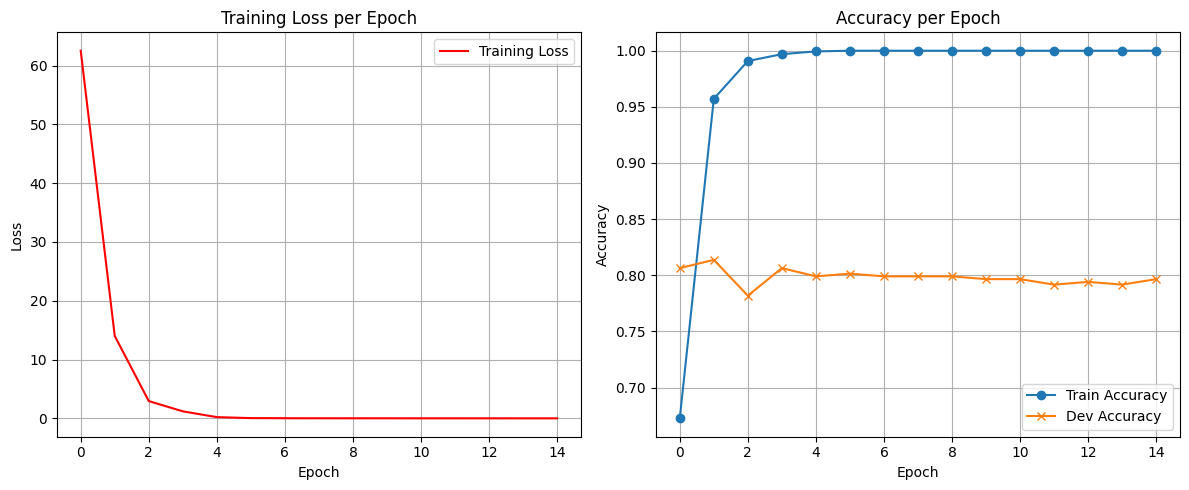


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7788    0.8284    0.8029       204
           1     0.8168    0.7647    0.7899       204

    accuracy                         0.7966       408
   macro avg     0.7978    0.7966    0.7964       408
weighted avg     0.7978    0.7966    0.7964       408

Confusion Matrix:
 [[169  35]
 [ 48 156]]


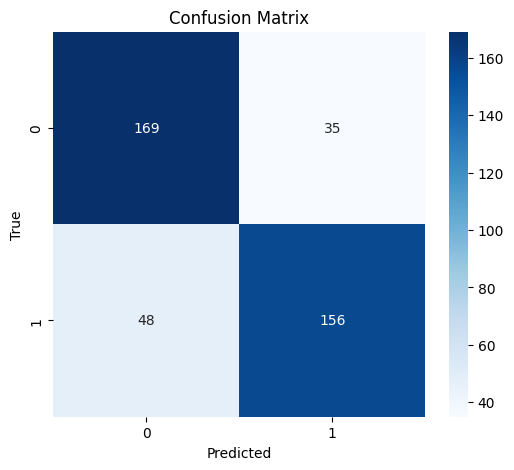


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7519    0.8534    0.7995       341
           1     0.8305    0.7185    0.7704       341

    accuracy                         0.7859       682
   macro avg     0.7912    0.7859    0.7849       682
weighted avg     0.7912    0.7859    0.7849       682

Confusion Matrix:
 [[291  50]
 [ 96 245]]


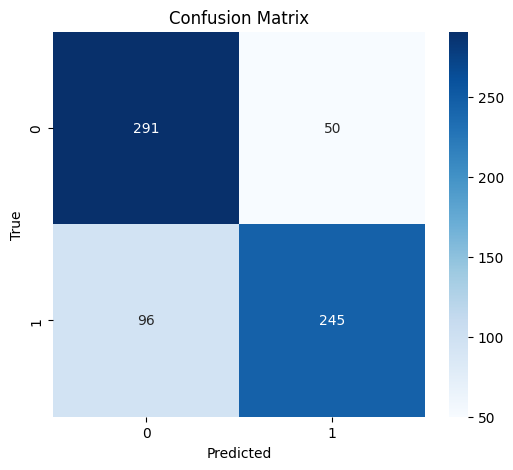

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 16
    lr = 1e-2
    epochs = 15
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# epoch = 20

Epoch 1: Loss = 63.5391, Train Acc = 0.6646, Dev Acc = 0.7770
Epoch 2: Loss = 16.1270, Train Acc = 0.9443, Dev Acc = 0.7745
Epoch 3: Loss = 2.6925, Train Acc = 0.9902, Dev Acc = 0.7966
Epoch 4: Loss = 0.8467, Train Acc = 0.9957, Dev Acc = 0.7794
Epoch 5: Loss = 0.1350, Train Acc = 1.0000, Dev Acc = 0.7721
Epoch 6: Loss = 0.0599, Train Acc = 1.0000, Dev Acc = 0.7696
Epoch 7: Loss = 0.0427, Train Acc = 1.0000, Dev Acc = 0.7745
Epoch 8: Loss = 0.0129, Train Acc = 1.0000, Dev Acc = 0.7647
Epoch 9: Loss = 0.0118, Train Acc = 1.0000, Dev Acc = 0.7672
Epoch 10: Loss = 0.0131, Train Acc = 1.0000, Dev Acc = 0.7721
Epoch 11: Loss = 0.0102, Train Acc = 1.0000, Dev Acc = 0.7696
Epoch 12: Loss = 0.0059, Train Acc = 1.0000, Dev Acc = 0.7672
Epoch 13: Loss = 0.0055, Train Acc = 1.0000, Dev Acc = 0.7696
Epoch 14: Loss = 0.0040, Train Acc = 1.0000, Dev Acc = 0.7721
Epoch 15: Loss = 0.0041, Train Acc = 1.0000, Dev Acc = 0.7770
Epoch 16: Loss = 0.0026, Train Acc = 1.0000, Dev Acc = 0.7770
Epoch 17: Loss 

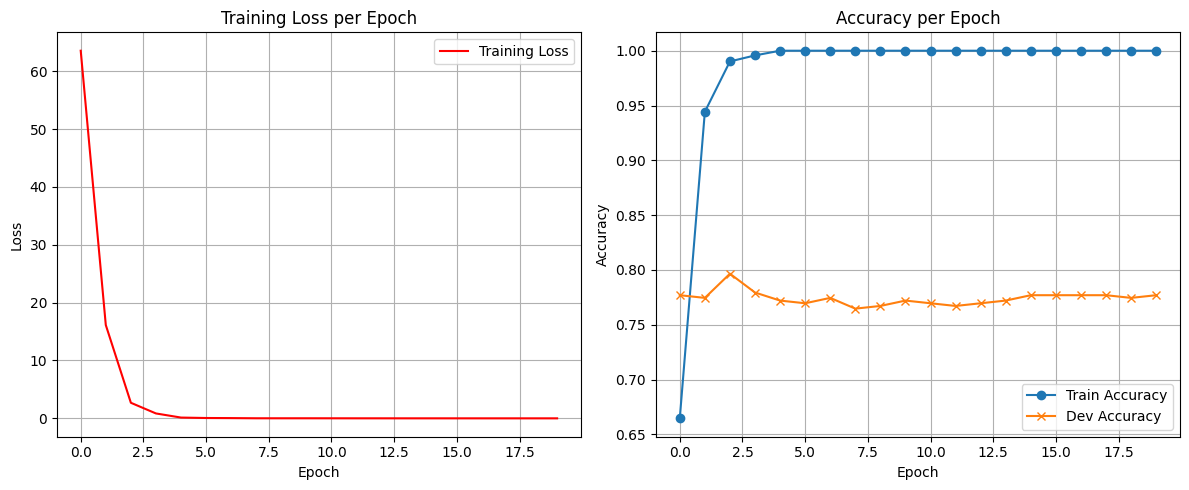


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8156    0.7157    0.7624       204
           1     0.7467    0.8382    0.7898       204

    accuracy                         0.7770       408
   macro avg     0.7812    0.7770    0.7761       408
weighted avg     0.7812    0.7770    0.7761       408

Confusion Matrix:
 [[146  58]
 [ 33 171]]


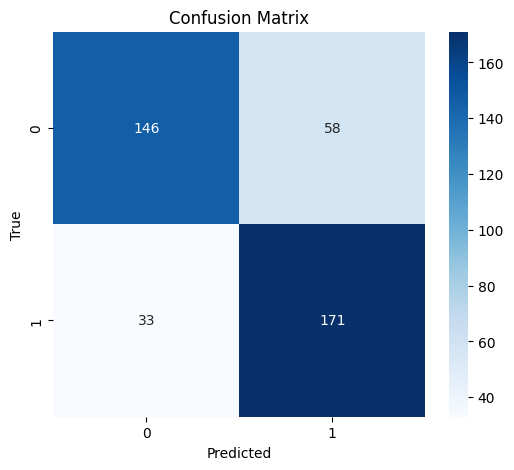


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7966    0.6891    0.7390       341
           1     0.7261    0.8240    0.7720       341

    accuracy                         0.7566       682
   macro avg     0.7614    0.7566    0.7555       682
weighted avg     0.7614    0.7566    0.7555       682

Confusion Matrix:
 [[235 106]
 [ 60 281]]


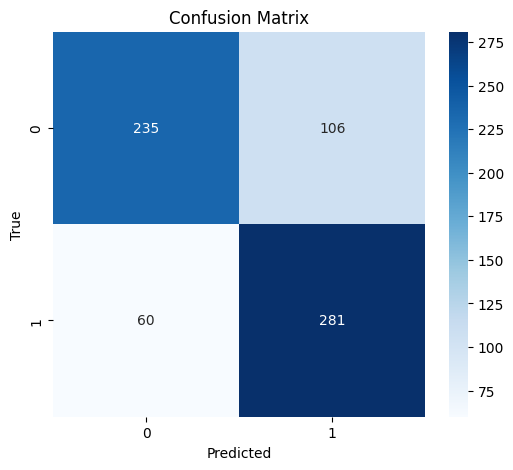

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 16
    lr = 1e-2
    epochs = 20
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Hid dim = 64

Epoch 1: Loss = 61.2336, Train Acc = 0.6683, Dev Acc = 0.7868
Epoch 2: Loss = 15.4335, Train Acc = 0.9547, Dev Acc = 0.7868
Epoch 3: Loss = 1.9611, Train Acc = 0.9927, Dev Acc = 0.7941
Epoch 4: Loss = 0.3250, Train Acc = 0.9994, Dev Acc = 0.7990
Epoch 5: Loss = 0.2116, Train Acc = 0.9994, Dev Acc = 0.8064
Epoch 6: Loss = 0.0343, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 7: Loss = 0.0148, Train Acc = 1.0000, Dev Acc = 0.8039
Epoch 8: Loss = 0.0107, Train Acc = 1.0000, Dev Acc = 0.8064
Epoch 9: Loss = 0.0090, Train Acc = 1.0000, Dev Acc = 0.8064
Epoch 10: Loss = 0.0101, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 11: Loss = 0.0040, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 12: Loss = 0.0054, Train Acc = 1.0000, Dev Acc = 0.8039
Epoch 13: Loss = 0.0035, Train Acc = 1.0000, Dev Acc = 0.8039
Epoch 14: Loss = 0.0037, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 15: Loss = 0.0029, Train Acc = 1.0000, Dev Acc = 0.7941


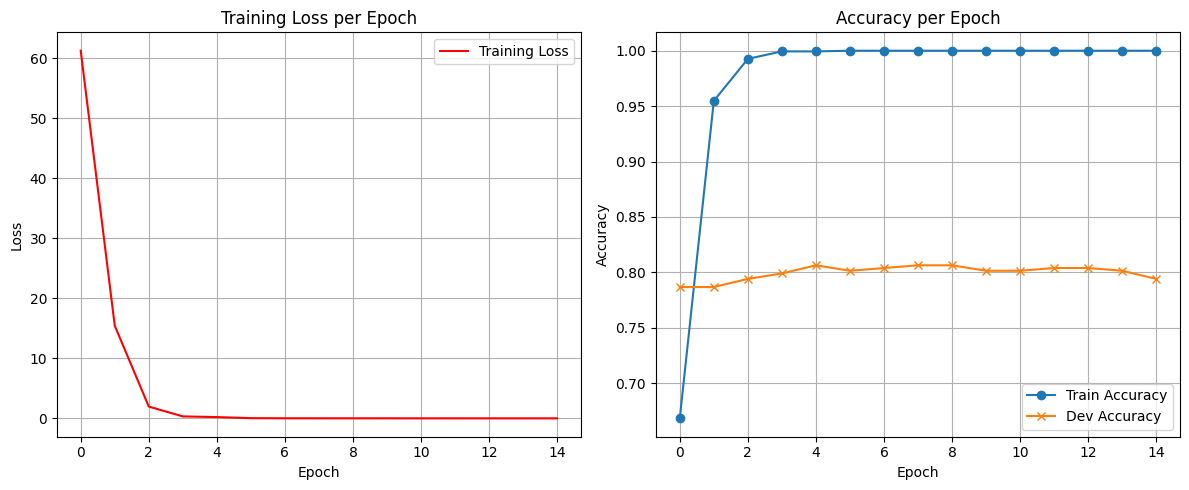


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8030    0.7794    0.7910       204
           1     0.7857    0.8088    0.7971       204

    accuracy                         0.7941       408
   macro avg     0.7944    0.7941    0.7941       408
weighted avg     0.7944    0.7941    0.7941       408

Confusion Matrix:
 [[159  45]
 [ 39 165]]


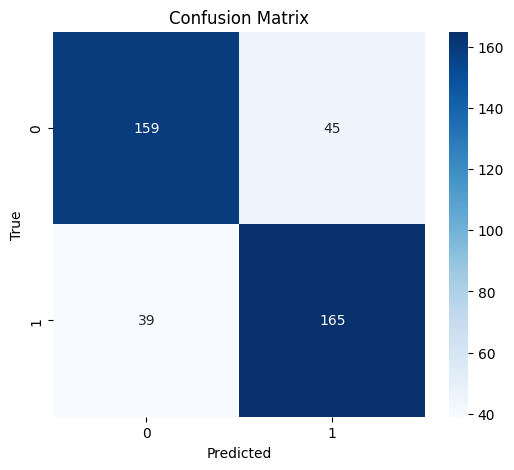


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7647    0.8006    0.7822       341
           1     0.7908    0.7537    0.7718       341

    accuracy                         0.7771       682
   macro avg     0.7777    0.7771    0.7770       682
weighted avg     0.7777    0.7771    0.7770       682

Confusion Matrix:
 [[273  68]
 [ 84 257]]


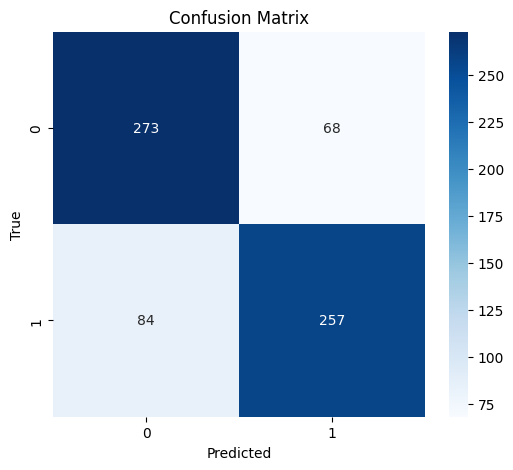

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 16
    lr = 1e-2
    epochs = 15
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Hid dim = 128

Epoch 1: Loss = 59.0653, Train Acc = 0.6726, Dev Acc = 0.7696
Epoch 2: Loss = 14.9574, Train Acc = 0.9492, Dev Acc = 0.7917
Epoch 3: Loss = 2.4293, Train Acc = 0.9927, Dev Acc = 0.7917
Epoch 4: Loss = 0.4370, Train Acc = 0.9988, Dev Acc = 0.8211
Epoch 5: Loss = 0.7091, Train Acc = 0.9976, Dev Acc = 0.8064
Epoch 6: Loss = 0.1346, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 7: Loss = 0.0204, Train Acc = 1.0000, Dev Acc = 0.8064
Epoch 8: Loss = 0.0129, Train Acc = 1.0000, Dev Acc = 0.8064
Epoch 9: Loss = 0.0080, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 10: Loss = 0.0055, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 11: Loss = 0.0044, Train Acc = 1.0000, Dev Acc = 0.8039
Epoch 12: Loss = 0.0032, Train Acc = 1.0000, Dev Acc = 0.8039
Epoch 13: Loss = 0.0025, Train Acc = 1.0000, Dev Acc = 0.8039
Epoch 14: Loss = 0.0018, Train Acc = 1.0000, Dev Acc = 0.8113
Epoch 15: Loss = 0.0018, Train Acc = 1.0000, Dev Acc = 0.8137


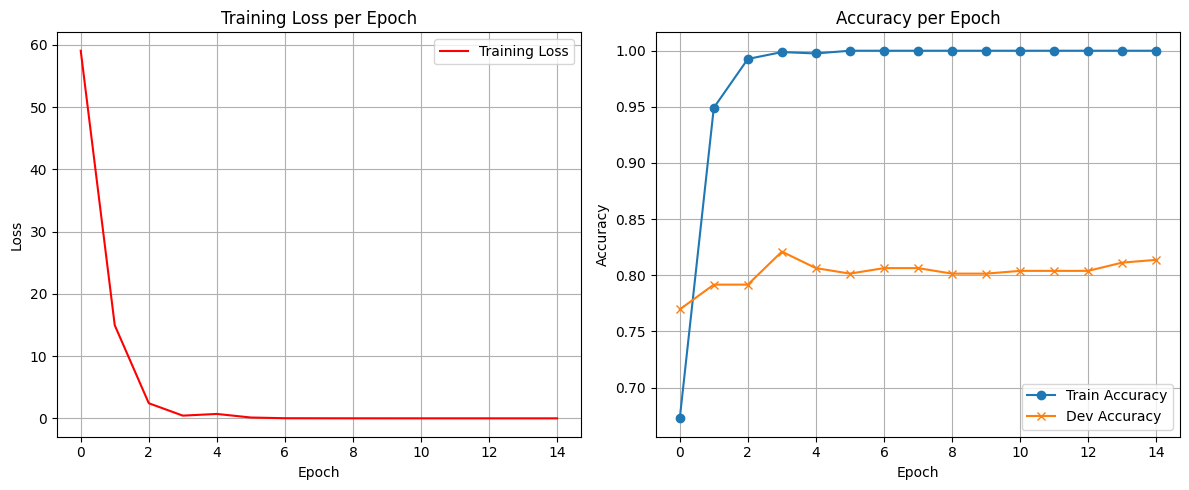


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8019    0.8333    0.8173       204
           1     0.8265    0.7941    0.8100       204

    accuracy                         0.8137       408
   macro avg     0.8142    0.8137    0.8137       408
weighted avg     0.8142    0.8137    0.8137       408

Confusion Matrix:
 [[170  34]
 [ 42 162]]


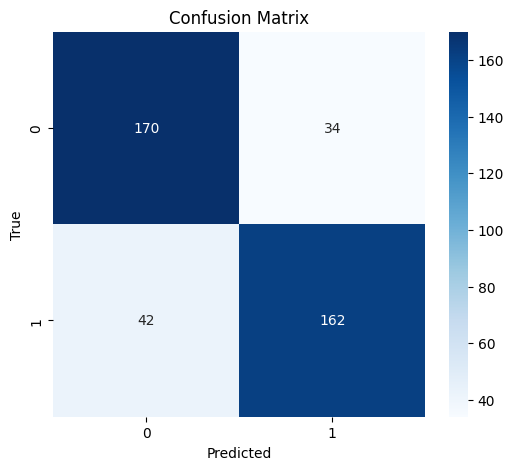


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7539    0.8446    0.7967       341
           1     0.8233    0.7243    0.7707       341

    accuracy                         0.7845       682
   macro avg     0.7886    0.7845    0.7837       682
weighted avg     0.7886    0.7845    0.7837       682

Confusion Matrix:
 [[288  53]
 [ 94 247]]


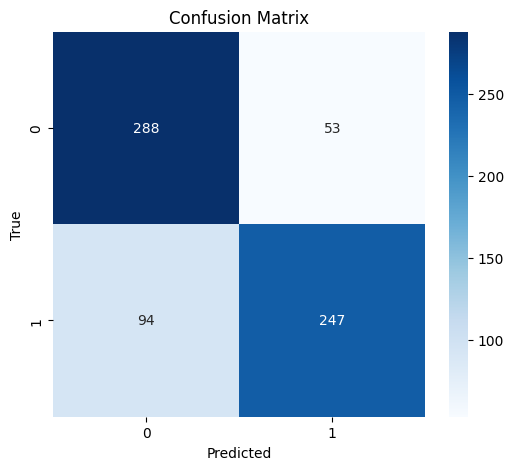

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 128
    batch_size = 16
    lr = 1e-2
    epochs = 15
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Hid dim = 256

Epoch 1: Loss = 60.1174, Train Acc = 0.6805, Dev Acc = 0.7843
Epoch 2: Loss = 15.8770, Train Acc = 0.9510, Dev Acc = 0.8113
Epoch 3: Loss = 2.6452, Train Acc = 0.9890, Dev Acc = 0.7941
Epoch 4: Loss = 0.5664, Train Acc = 0.9976, Dev Acc = 0.7574
Epoch 5: Loss = 0.6998, Train Acc = 0.9988, Dev Acc = 0.7549
Epoch 6: Loss = 0.1776, Train Acc = 0.9994, Dev Acc = 0.7990
Epoch 7: Loss = 0.0618, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 8: Loss = 0.2422, Train Acc = 0.9988, Dev Acc = 0.7892
Epoch 9: Loss = 1.7926, Train Acc = 0.9969, Dev Acc = 0.8039
Epoch 10: Loss = 0.4187, Train Acc = 0.9982, Dev Acc = 0.7843
Epoch 11: Loss = 0.0853, Train Acc = 1.0000, Dev Acc = 0.7917
Epoch 12: Loss = 0.0165, Train Acc = 1.0000, Dev Acc = 0.7843
Epoch 13: Loss = 0.0050, Train Acc = 1.0000, Dev Acc = 0.7917
Epoch 14: Loss = 0.0033, Train Acc = 1.0000, Dev Acc = 0.7917
Epoch 15: Loss = 0.0031, Train Acc = 1.0000, Dev Acc = 0.7917


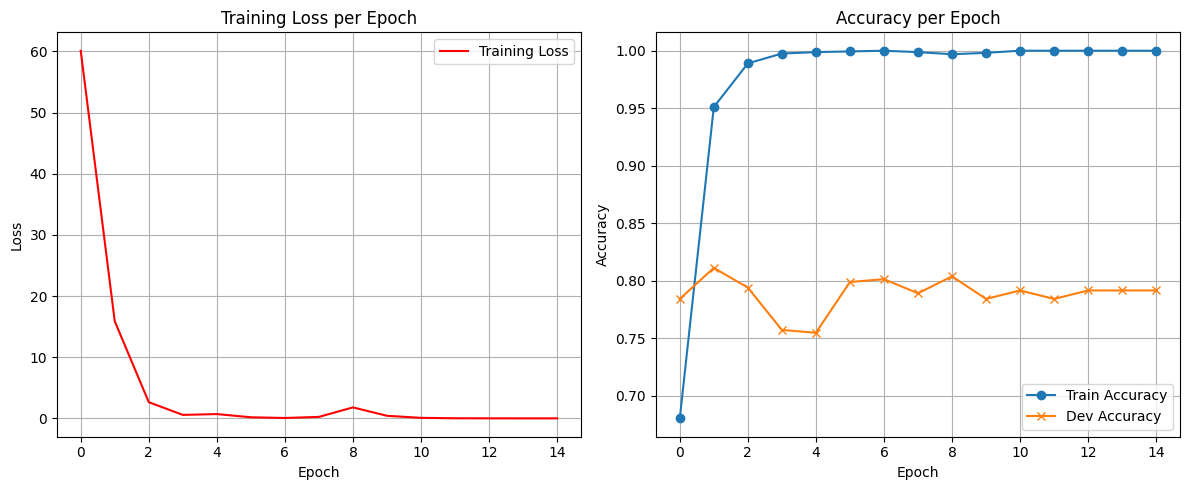


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8324    0.7304    0.7781       204
           1     0.7598    0.8529    0.8037       204

    accuracy                         0.7917       408
   macro avg     0.7961    0.7917    0.7909       408
weighted avg     0.7961    0.7917    0.7909       408

Confusion Matrix:
 [[149  55]
 [ 30 174]]


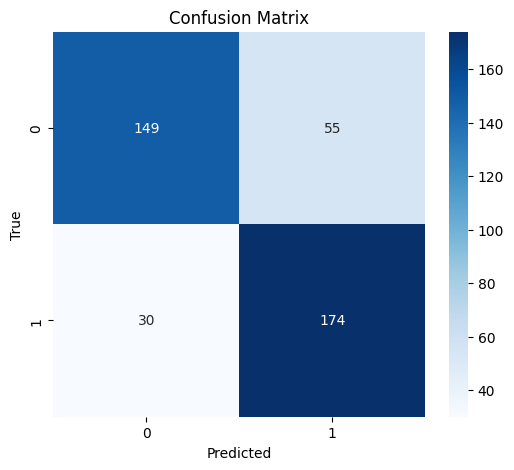


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8301    0.7595    0.7933       341
           1     0.7784    0.8446    0.8101       341

    accuracy                         0.8021       682
   macro avg     0.8043    0.8021    0.8017       682
weighted avg     0.8043    0.8021    0.8017       682

Confusion Matrix:
 [[259  82]
 [ 53 288]]


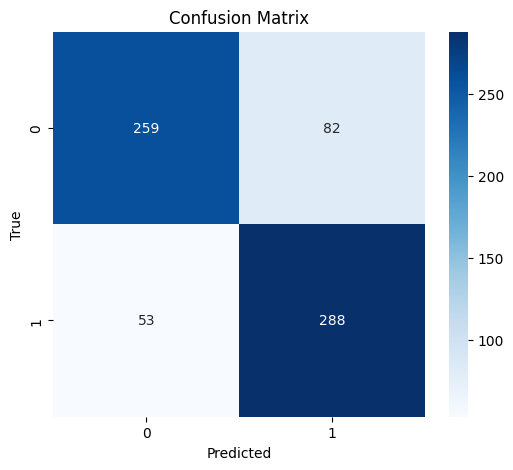

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 256
    batch_size = 16
    lr = 1e-2
    epochs = 15
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Drop = 0.2

Epoch 1: Loss = 60.3468, Train Acc = 0.6652, Dev Acc = 0.7672
Epoch 2: Loss = 14.9363, Train Acc = 0.9510, Dev Acc = 0.7525
Epoch 3: Loss = 3.1161, Train Acc = 0.9914, Dev Acc = 0.7623
Epoch 4: Loss = 1.0821, Train Acc = 0.9951, Dev Acc = 0.7819
Epoch 5: Loss = 0.1939, Train Acc = 0.9994, Dev Acc = 0.7794
Epoch 6: Loss = 0.0455, Train Acc = 1.0000, Dev Acc = 0.7696
Epoch 7: Loss = 0.0198, Train Acc = 1.0000, Dev Acc = 0.7721
Epoch 8: Loss = 0.0130, Train Acc = 1.0000, Dev Acc = 0.7745
Epoch 9: Loss = 0.0072, Train Acc = 1.0000, Dev Acc = 0.7745
Epoch 10: Loss = 0.0054, Train Acc = 1.0000, Dev Acc = 0.7745
Epoch 11: Loss = 0.0036, Train Acc = 1.0000, Dev Acc = 0.7794
Epoch 12: Loss = 0.0027, Train Acc = 1.0000, Dev Acc = 0.7770
Epoch 13: Loss = 0.0028, Train Acc = 1.0000, Dev Acc = 0.7794
Epoch 14: Loss = 0.0023, Train Acc = 1.0000, Dev Acc = 0.7770
Epoch 15: Loss = 0.0020, Train Acc = 1.0000, Dev Acc = 0.7794


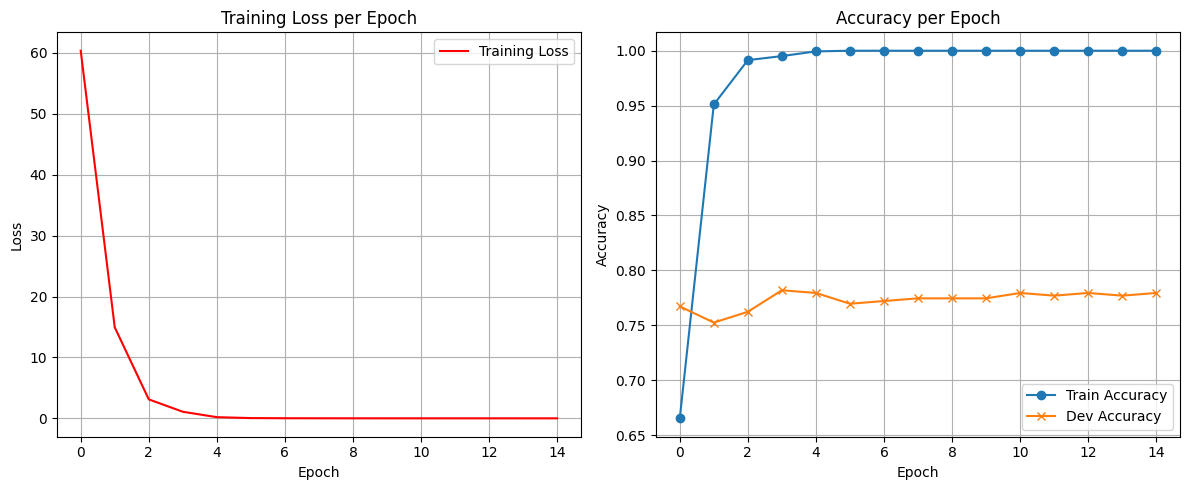


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7209    0.9118    0.8052       204
           1     0.8800    0.6471    0.7458       204

    accuracy                         0.7794       408
   macro avg     0.8005    0.7794    0.7755       408
weighted avg     0.8005    0.7794    0.7755       408

Confusion Matrix:
 [[186  18]
 [ 72 132]]


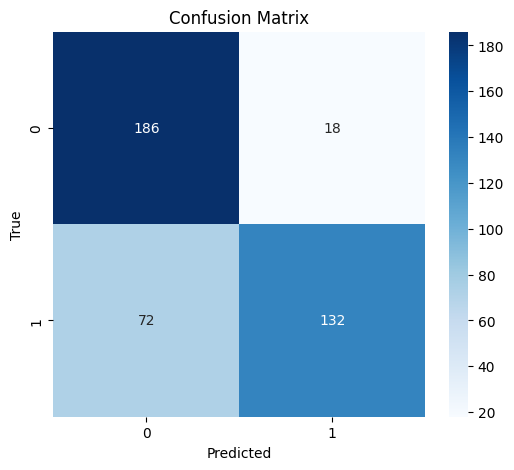


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.6991    0.9062    0.7893       341
           1     0.8667    0.6100    0.7160       341

    accuracy                         0.7581       682
   macro avg     0.7829    0.7581    0.7526       682
weighted avg     0.7829    0.7581    0.7526       682

Confusion Matrix:
 [[309  32]
 [133 208]]


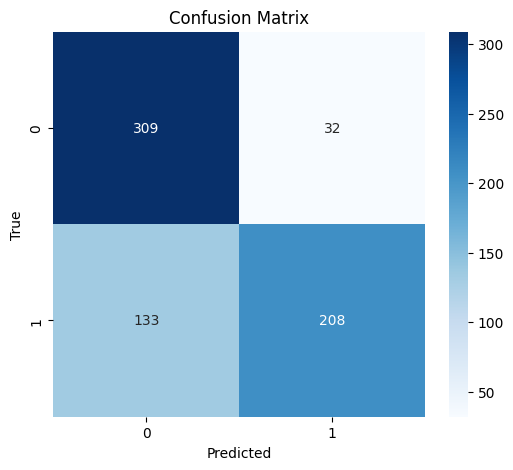

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 128
    batch_size = 16
    lr = 1e-2
    epochs = 15
    dropout = 0.2
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Drop = 0.3

Epoch 1: Loss = 59.0466, Train Acc = 0.6775, Dev Acc = 0.7843
Epoch 2: Loss = 15.5423, Train Acc = 0.9412, Dev Acc = 0.8015
Epoch 3: Loss = 2.1674, Train Acc = 0.9939, Dev Acc = 0.8186
Epoch 4: Loss = 0.5261, Train Acc = 0.9988, Dev Acc = 0.7917
Epoch 5: Loss = 0.1433, Train Acc = 0.9994, Dev Acc = 0.7966
Epoch 6: Loss = 0.0284, Train Acc = 1.0000, Dev Acc = 0.7941
Epoch 7: Loss = 0.0174, Train Acc = 1.0000, Dev Acc = 0.8039
Epoch 8: Loss = 0.0062, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 9: Loss = 0.0049, Train Acc = 1.0000, Dev Acc = 0.8064
Epoch 10: Loss = 0.0030, Train Acc = 1.0000, Dev Acc = 0.8064
Epoch 11: Loss = 0.0024, Train Acc = 1.0000, Dev Acc = 0.8039
Epoch 12: Loss = 0.0032, Train Acc = 1.0000, Dev Acc = 0.8064
Epoch 13: Loss = 0.0024, Train Acc = 1.0000, Dev Acc = 0.8064
Epoch 14: Loss = 0.0014, Train Acc = 1.0000, Dev Acc = 0.8039
Epoch 15: Loss = 0.0011, Train Acc = 1.0000, Dev Acc = 0.8064


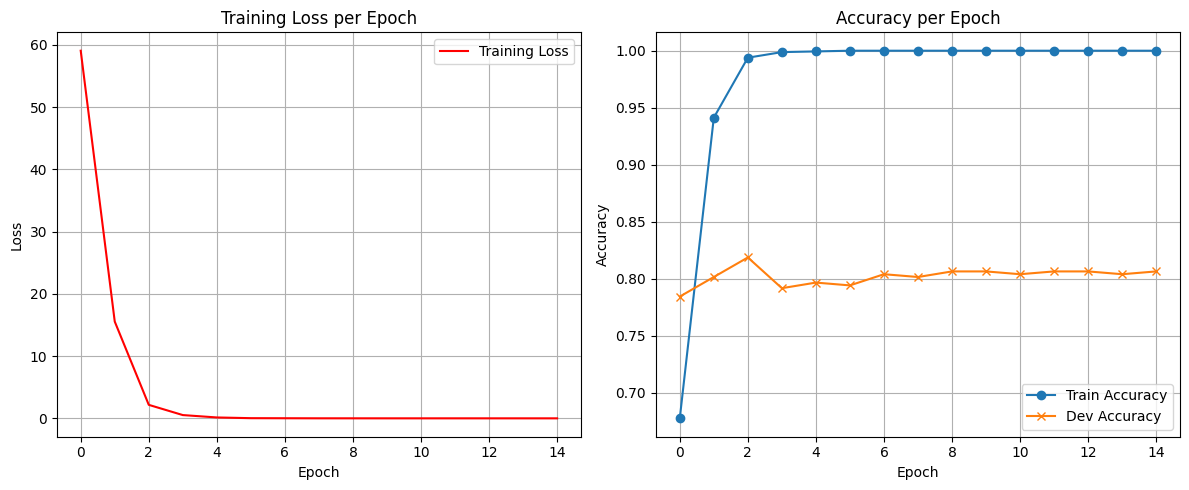


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8342    0.7647    0.7980       204
           1     0.7828    0.8480    0.8141       204

    accuracy                         0.8064       408
   macro avg     0.8085    0.8064    0.8060       408
weighted avg     0.8085    0.8064    0.8060       408

Confusion Matrix:
 [[156  48]
 [ 31 173]]


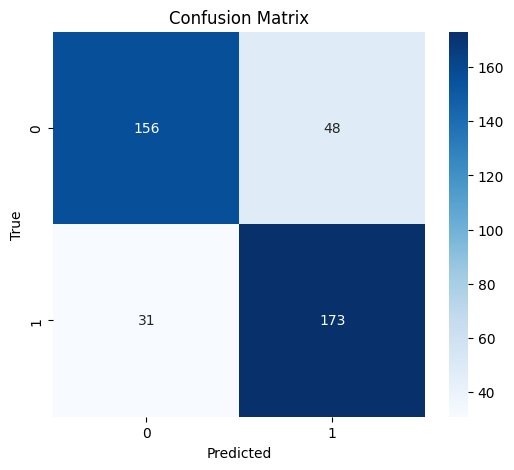


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7994    0.7713    0.7851       341
           1     0.7790    0.8065    0.7925       341

    accuracy                         0.7889       682
   macro avg     0.7892    0.7889    0.7888       682
weighted avg     0.7892    0.7889    0.7888       682

Confusion Matrix:
 [[263  78]
 [ 66 275]]


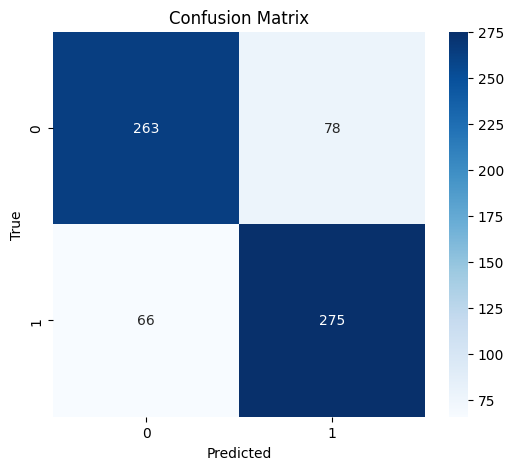

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 128
    batch_size = 16
    lr = 1e-2
    epochs = 15
    dropout = 0.2
    use_bilstm = False
    optimizer_name = "Adam"
    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Drop = 0.5

Epoch 1: Loss = 61.7203, Train Acc = 0.6775, Dev Acc = 0.7892
Epoch 2: Loss = 17.3595, Train Acc = 0.9394, Dev Acc = 0.7966
Epoch 3: Loss = 2.9760, Train Acc = 0.9896, Dev Acc = 0.7843
Epoch 4: Loss = 0.7220, Train Acc = 0.9988, Dev Acc = 0.7843
Epoch 5: Loss = 0.7785, Train Acc = 0.9988, Dev Acc = 0.7745
Epoch 6: Loss = 0.4403, Train Acc = 0.9994, Dev Acc = 0.7990
Epoch 7: Loss = 0.0418, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 8: Loss = 0.0084, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 9: Loss = 0.0158, Train Acc = 1.0000, Dev Acc = 0.7917
Epoch 10: Loss = 0.0090, Train Acc = 1.0000, Dev Acc = 0.7868
Epoch 11: Loss = 0.0072, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 12: Loss = 0.0042, Train Acc = 1.0000, Dev Acc = 0.7990
Epoch 13: Loss = 0.0039, Train Acc = 1.0000, Dev Acc = 0.7990
Epoch 14: Loss = 0.0038, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 15: Loss = 0.0029, Train Acc = 1.0000, Dev Acc = 0.7990


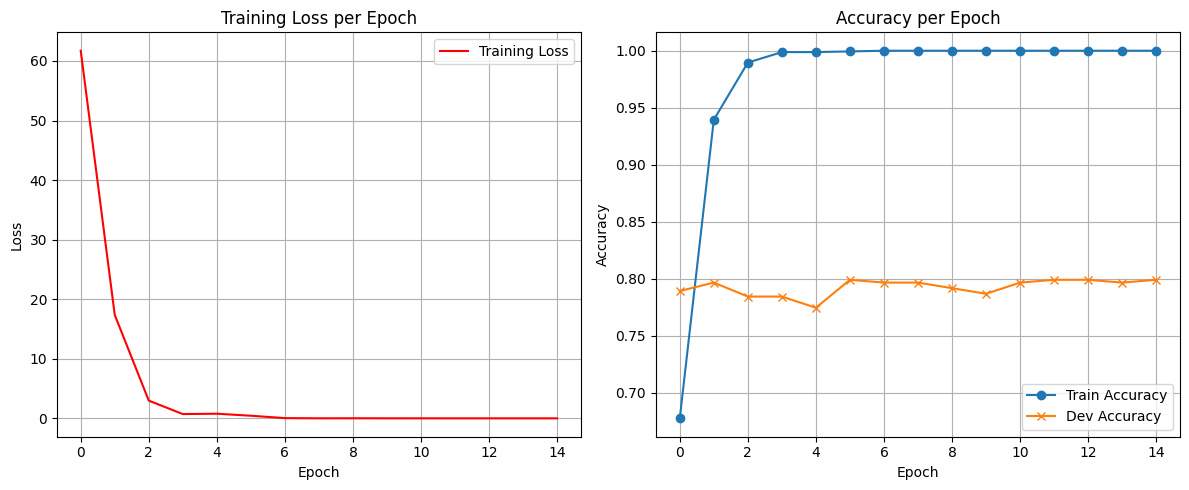


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7773    0.8382    0.8066       204
           1     0.8245    0.7598    0.7908       204

    accuracy                         0.7990       408
   macro avg     0.8009    0.7990    0.7987       408
weighted avg     0.8009    0.7990    0.7987       408

Confusion Matrix:
 [[171  33]
 [ 49 155]]


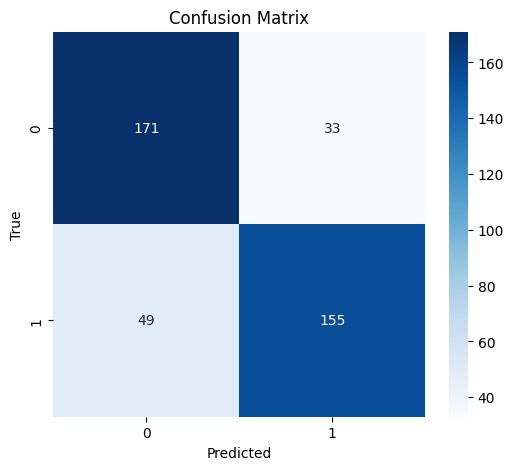


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7558    0.8534    0.8017       341
           1     0.8316    0.7243    0.7743       341

    accuracy                         0.7889       682
   macro avg     0.7937    0.7889    0.7880       682
weighted avg     0.7937    0.7889    0.7880       682

Confusion Matrix:
 [[291  50]
 [ 94 247]]


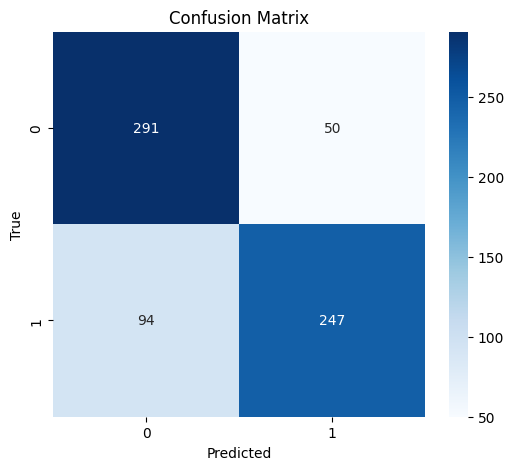

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 128
    batch_size = 16
    lr = 1e-2
    epochs = 15
    dropout = 0.5
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Optimizer = Adam

Epoch 1: Loss = 62.1105, Train Acc = 0.6414, Dev Acc = 0.7598
Epoch 2: Loss = 16.9930, Train Acc = 0.9406, Dev Acc = 0.7990
Epoch 3: Loss = 2.9197, Train Acc = 0.9902, Dev Acc = 0.7941
Epoch 4: Loss = 0.8213, Train Acc = 0.9976, Dev Acc = 0.8186
Epoch 5: Loss = 0.0992, Train Acc = 1.0000, Dev Acc = 0.8235
Epoch 6: Loss = 0.0430, Train Acc = 1.0000, Dev Acc = 0.8260
Epoch 7: Loss = 0.0203, Train Acc = 1.0000, Dev Acc = 0.8211
Epoch 8: Loss = 0.0125, Train Acc = 1.0000, Dev Acc = 0.8137
Epoch 9: Loss = 0.0078, Train Acc = 1.0000, Dev Acc = 0.8113
Epoch 10: Loss = 0.0053, Train Acc = 1.0000, Dev Acc = 0.8137
Epoch 11: Loss = 0.0030, Train Acc = 1.0000, Dev Acc = 0.8064
Epoch 12: Loss = 0.0031, Train Acc = 1.0000, Dev Acc = 0.8064
Epoch 13: Loss = 0.0031, Train Acc = 1.0000, Dev Acc = 0.8064
Epoch 14: Loss = 0.0036, Train Acc = 1.0000, Dev Acc = 0.8137
Epoch 15: Loss = 0.0026, Train Acc = 1.0000, Dev Acc = 0.8162


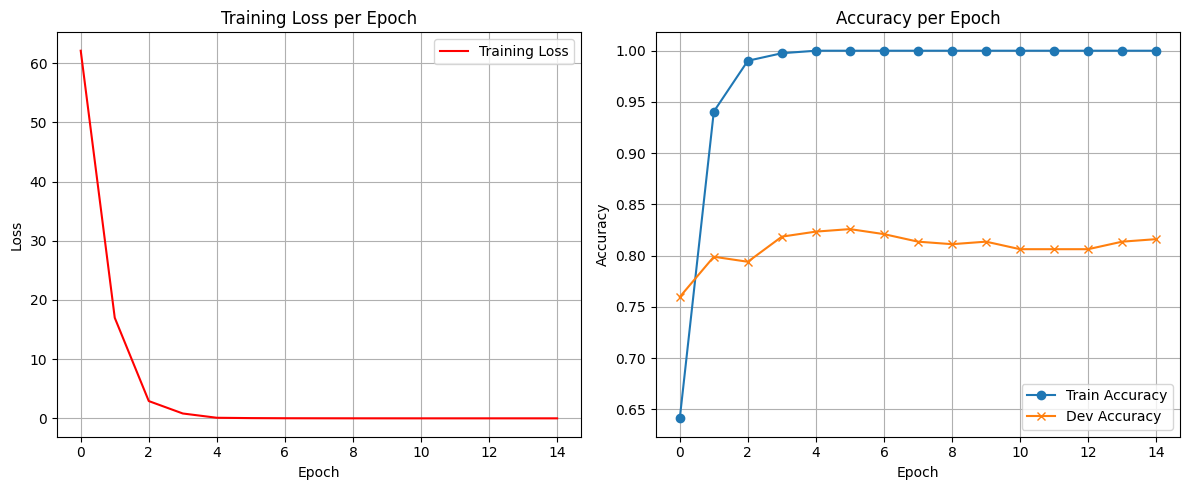


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7945    0.8529    0.8227       204
           1     0.8413    0.7794    0.8092       204

    accuracy                         0.8162       408
   macro avg     0.8179    0.8162    0.8159       408
weighted avg     0.8179    0.8162    0.8159       408

Confusion Matrix:
 [[174  30]
 [ 45 159]]


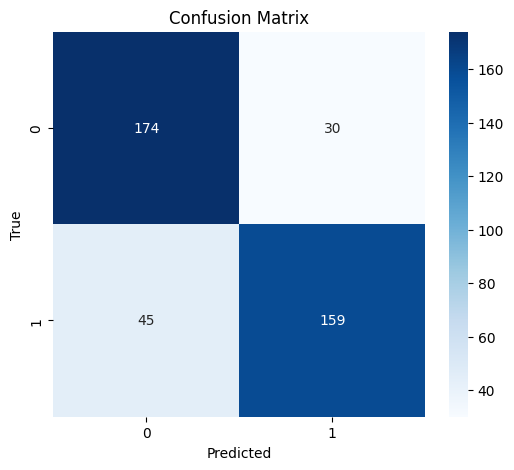


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7713    0.8504    0.8089       341
           1     0.8333    0.7478    0.7883       341

    accuracy                         0.7991       682
   macro avg     0.8023    0.7991    0.7986       682
weighted avg     0.8023    0.7991    0.7986       682

Confusion Matrix:
 [[290  51]
 [ 86 255]]


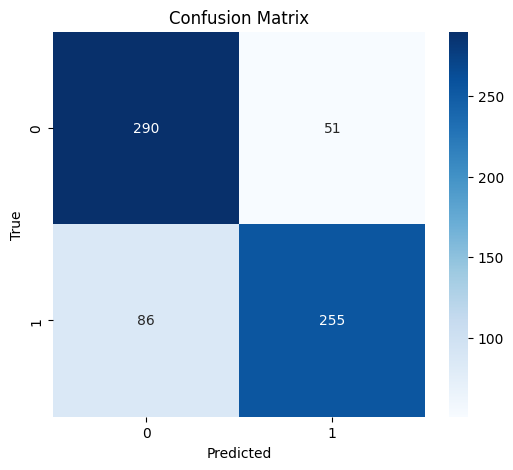

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 128
    batch_size = 16
    lr = 1e-2
    epochs = 15
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Optimzer = SGD

Epoch 1: Loss = 71.4380, Train Acc = 0.4988, Dev Acc = 0.5098
Epoch 2: Loss = 71.3228, Train Acc = 0.5165, Dev Acc = 0.5147
Epoch 3: Loss = 71.2595, Train Acc = 0.5318, Dev Acc = 0.5735
Epoch 4: Loss = 71.2332, Train Acc = 0.5410, Dev Acc = 0.6176
Epoch 5: Loss = 71.0845, Train Acc = 0.5575, Dev Acc = 0.6201
Epoch 6: Loss = 70.9902, Train Acc = 0.5753, Dev Acc = 0.6348
Epoch 7: Loss = 70.9102, Train Acc = 0.5832, Dev Acc = 0.6618
Epoch 8: Loss = 70.9917, Train Acc = 0.5692, Dev Acc = 0.6422
Epoch 9: Loss = 70.6523, Train Acc = 0.5912, Dev Acc = 0.6544
Epoch 10: Loss = 70.6088, Train Acc = 0.5979, Dev Acc = 0.6667
Epoch 11: Loss = 70.5137, Train Acc = 0.6059, Dev Acc = 0.6495
Epoch 12: Loss = 70.4338, Train Acc = 0.5930, Dev Acc = 0.6691
Epoch 13: Loss = 70.3763, Train Acc = 0.5985, Dev Acc = 0.6569
Epoch 14: Loss = 70.2626, Train Acc = 0.6108, Dev Acc = 0.6716
Epoch 15: Loss = 70.1322, Train Acc = 0.6047, Dev Acc = 0.6569


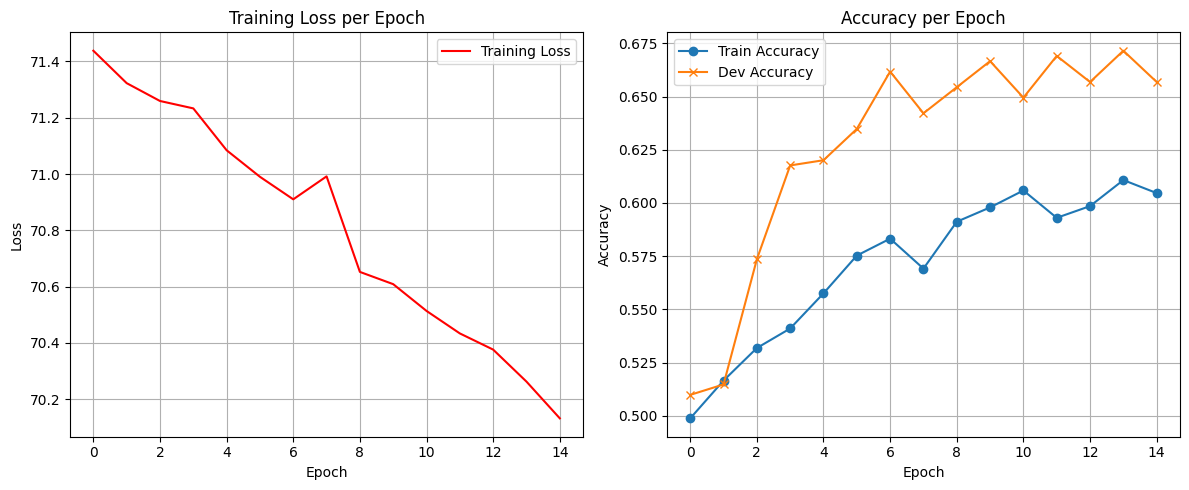


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.6702    0.6176    0.6429       204
           1     0.6455    0.6961    0.6698       204

    accuracy                         0.6569       408
   macro avg     0.6578    0.6569    0.6563       408
weighted avg     0.6578    0.6569    0.6563       408

Confusion Matrix:
 [[126  78]
 [ 62 142]]


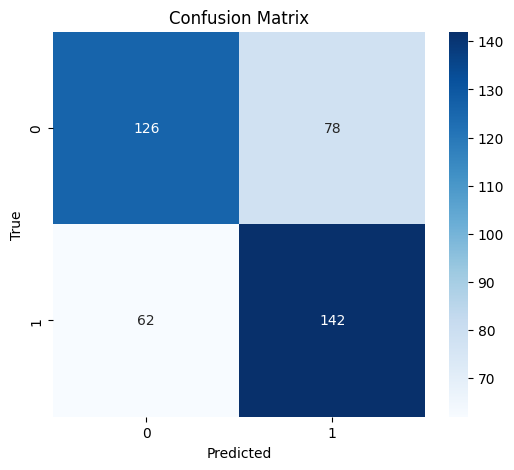


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.6208    0.5953    0.6078       341
           1     0.6113    0.6364    0.6236       341

    accuracy                         0.6158       682
   macro avg     0.6160    0.6158    0.6157       682
weighted avg     0.6160    0.6158    0.6157       682

Confusion Matrix:
 [[203 138]
 [124 217]]


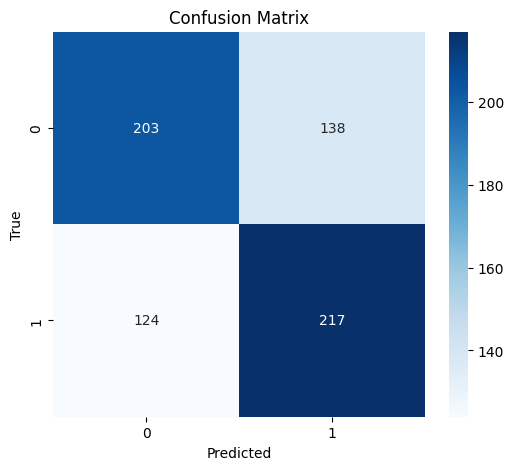

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 128
    batch_size = 16
    lr = 1e-2
    epochs = 15
    dropout = 0.3
    use_bilstm = False  # 🔁 غيريها إلى False إذا بدك LSTM عادي
    optimizer_name = "SGD"  # ✅ أضفنا الـ optimizer كـ hyperparameter

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Glove Dim = 100

Epoch 1: Loss = 61.3477, Train Acc = 0.6671, Dev Acc = 0.7892
Epoch 2: Loss = 18.3249, Train Acc = 0.9406, Dev Acc = 0.7598
Epoch 3: Loss = 3.1717, Train Acc = 0.9920, Dev Acc = 0.7574
Epoch 4: Loss = 0.5426, Train Acc = 0.9976, Dev Acc = 0.7819
Epoch 5: Loss = 1.5953, Train Acc = 0.9957, Dev Acc = 0.7598
Epoch 6: Loss = 0.1612, Train Acc = 1.0000, Dev Acc = 0.7721
Epoch 7: Loss = 0.0273, Train Acc = 1.0000, Dev Acc = 0.7770
Epoch 8: Loss = 0.0132, Train Acc = 1.0000, Dev Acc = 0.7819
Epoch 9: Loss = 0.0095, Train Acc = 1.0000, Dev Acc = 0.7868
Epoch 10: Loss = 0.0054, Train Acc = 1.0000, Dev Acc = 0.7941
Epoch 11: Loss = 0.0038, Train Acc = 1.0000, Dev Acc = 0.7941
Epoch 12: Loss = 0.0036, Train Acc = 1.0000, Dev Acc = 0.7941
Epoch 13: Loss = 0.0023, Train Acc = 1.0000, Dev Acc = 0.7941
Epoch 14: Loss = 0.0024, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 15: Loss = 0.0020, Train Acc = 1.0000, Dev Acc = 0.7966


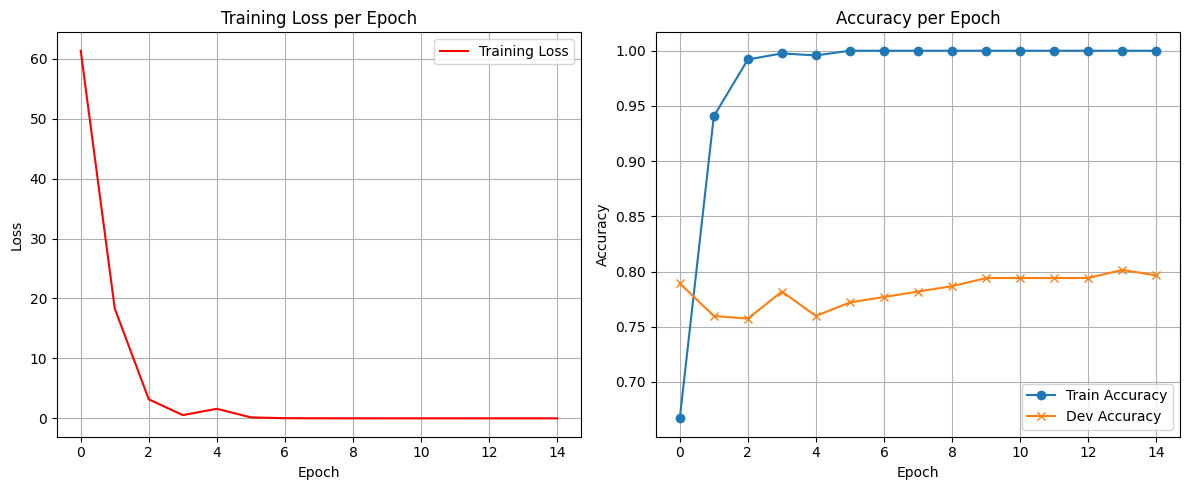


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8380    0.7353    0.7833       204
           1     0.7642    0.8578    0.8083       204

    accuracy                         0.7966       408
   macro avg     0.8011    0.7966    0.7958       408
weighted avg     0.8011    0.7966    0.7958       408

Confusion Matrix:
 [[150  54]
 [ 29 175]]


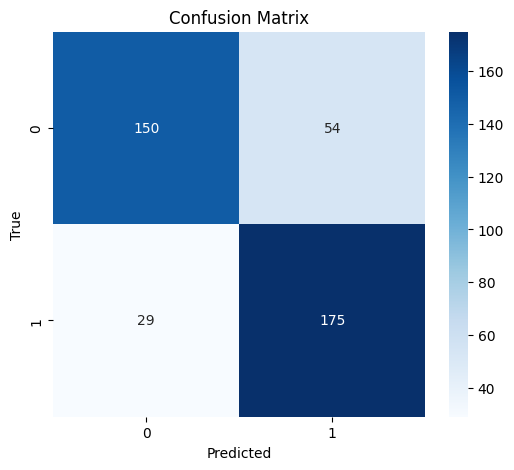


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8056    0.7654    0.7850       341
           1     0.7765    0.8152    0.7954       341

    accuracy                         0.7903       682
   macro avg     0.7910    0.7903    0.7902       682
weighted avg     0.7910    0.7903    0.7902       682

Confusion Matrix:
 [[261  80]
 [ 63 278]]


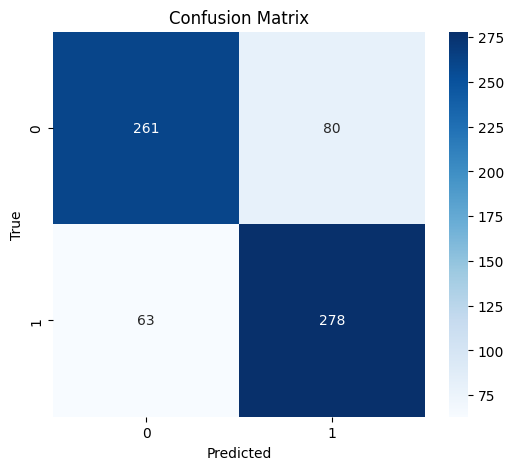

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 128
    batch_size = 16
    lr = 1e-2
    epochs = 15
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Glove Dim = 300

Epoch 1: Loss = 58.2068, Train Acc = 0.6940, Dev Acc = 0.7941
Epoch 2: Loss = 10.6261, Train Acc = 0.9663, Dev Acc = 0.7475
Epoch 3: Loss = 1.5602, Train Acc = 0.9927, Dev Acc = 0.7696
Epoch 4: Loss = 0.6943, Train Acc = 0.9976, Dev Acc = 0.7770
Epoch 5: Loss = 0.1038, Train Acc = 1.0000, Dev Acc = 0.7672
Epoch 6: Loss = 0.0316, Train Acc = 1.0000, Dev Acc = 0.7721
Epoch 7: Loss = 0.0138, Train Acc = 1.0000, Dev Acc = 0.7819
Epoch 8: Loss = 0.0104, Train Acc = 1.0000, Dev Acc = 0.7843
Epoch 9: Loss = 0.0092, Train Acc = 1.0000, Dev Acc = 0.7868
Epoch 10: Loss = 0.0069, Train Acc = 1.0000, Dev Acc = 0.7892
Epoch 11: Loss = 0.0042, Train Acc = 1.0000, Dev Acc = 0.7917
Epoch 12: Loss = 0.0026, Train Acc = 1.0000, Dev Acc = 0.7917
Epoch 13: Loss = 0.0029, Train Acc = 1.0000, Dev Acc = 0.7941
Epoch 14: Loss = 0.0024, Train Acc = 1.0000, Dev Acc = 0.7941
Epoch 15: Loss = 0.0017, Train Acc = 1.0000, Dev Acc = 0.7941


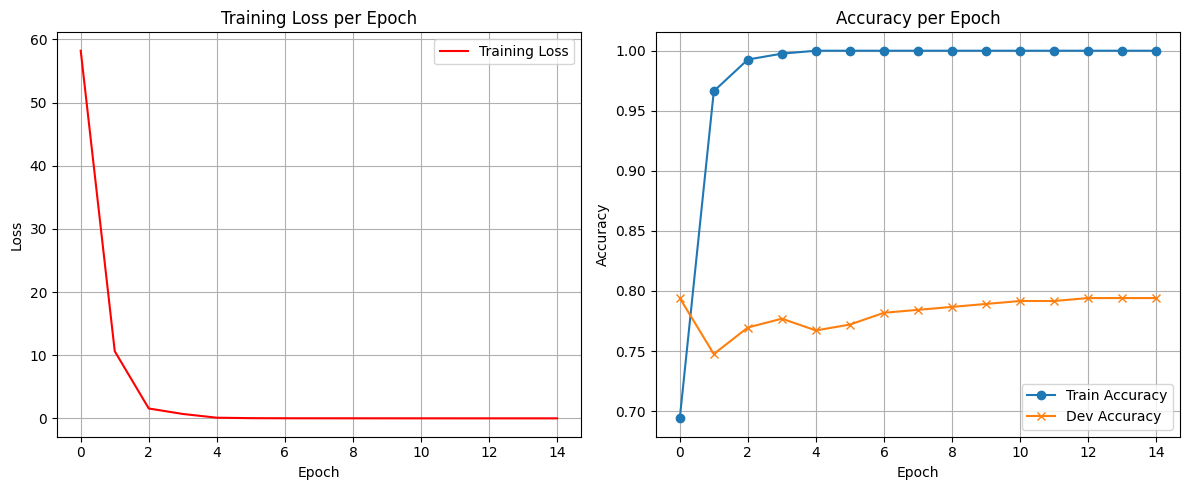


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7727    0.8333    0.8019       204
           1     0.8191    0.7549    0.7857       204

    accuracy                         0.7941       408
   macro avg     0.7959    0.7941    0.7938       408
weighted avg     0.7959    0.7941    0.7938       408

Confusion Matrix:
 [[170  34]
 [ 50 154]]


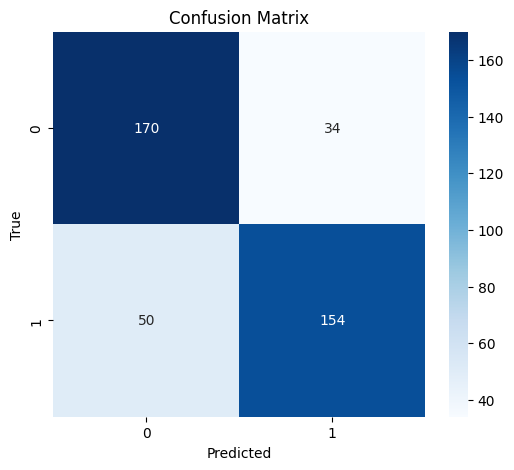


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7513    0.8592    0.8016       341
           1     0.8356    0.7155    0.7709       341

    accuracy                         0.7874       682
   macro avg     0.7934    0.7874    0.7863       682
weighted avg     0.7934    0.7874    0.7863       682

Confusion Matrix:
 [[293  48]
 [ 97 244]]


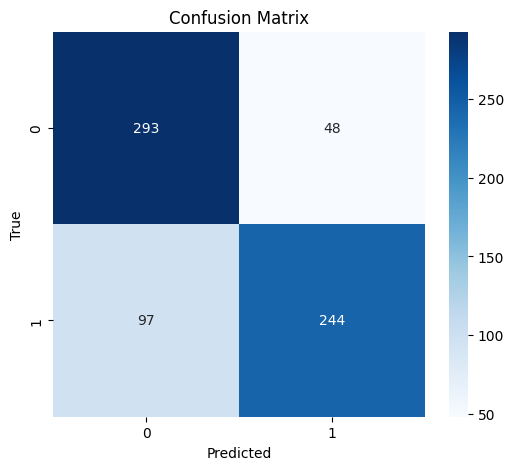

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.300d.txt"
    embedding_dim = 300
    hidden_dim = 128
    batch_size = 16
    lr = 1e-2
    epochs = 15
    dropout = 0.3
    use_bilstm = False  # 🔁 غيريها إلى False إذا بدك LSTM عادي
    optimizer_name = "Adam"  # ✅ أضفنا الـ optimizer كـ hyperparameter

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()
